# Tarea semanal 9
## Nicolás Albano 
### Consignas

Parte 1 - Diseño de filtros

Se necesita eliminar las interferencias de una señal electrocardiográfica (ECG) que fue registrada a una frecuencia de muestreo de 1 kHz. Para ello se propone la siguiente plantilla de diseño:

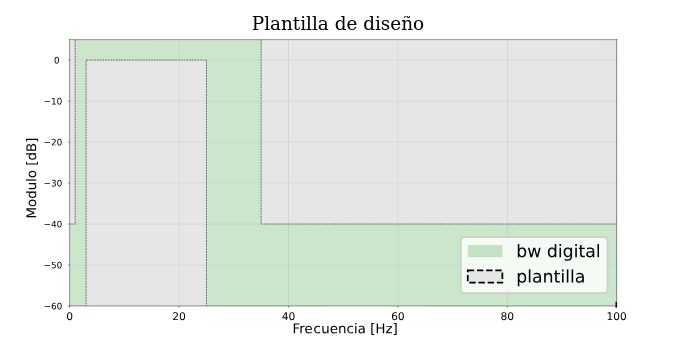

y se pide diseñar dos filtros: uno IIR y otro FIR que cumplan con la plantilla, utilizando alguno de los métodos estudiados. Mostrar la respuesta en frecuencia, para ambos filtros, de:

a) módulo,

b) fase

c) retardo

d) y respuesta al impulso.

Parte II - Implementación y uso

En esta parte utilizaremos los dos filtros diseñados para mitigar las interferencias. Para ello se dispone de un notebook de referencia para facilitar la experimentación.

In [1]:
# Inicialización e importación de módulos

# Módulos para Jupyter
import warnings
warnings.filterwarnings('ignore')

# Módulos importantantes
import scipy.signal as sig
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.io as sio
from pytc2.sistemas_lineales import plot_plantilla

fig_sz_x = 10
fig_sz_y = 7
fig_dpi = 100 # dpi

fig_font_size = 16

mpl.rcParams['figure.figsize'] = (fig_sz_x,fig_sz_y)
plt.rcParams.update({'font.size':fig_font_size})

###
## Señal de ECG registrada a 1 kHz, con contaminación de diversos orígenes.
###

# para listar las variables que hay en el archivo
#io.whosmat('ecg.mat')
mat_struct = sio.loadmat('ecg.mat')

ecg_one_lead = mat_struct['ecg_lead']
ecg_one_lead = ecg_one_lead.flatten()
cant_muestras = len(ecg_one_lead)

fs = 1000 # Hz
nyq_frec = fs / 2

In [2]:

# Plantilla

# filter design
ripple = 0.1 # dB
atenuacion = 40 # dB

ws1 = 1.0 #Hz
wp1 = 3.0 #Hz
wp2 = 25.0 #Hz
ws2 = 35.0 #Hz
frecs= np.array([0.0,         ws1,         wp1,     wp2,     ws2,         nyq_frec   ]) / nyq_frec
gains = np.array([-atenuacion, -atenuacion, -ripple, -ripple, -atenuacion, -atenuacion])
gains = 10**(gains/20)




El filtro tiene 5 SOS


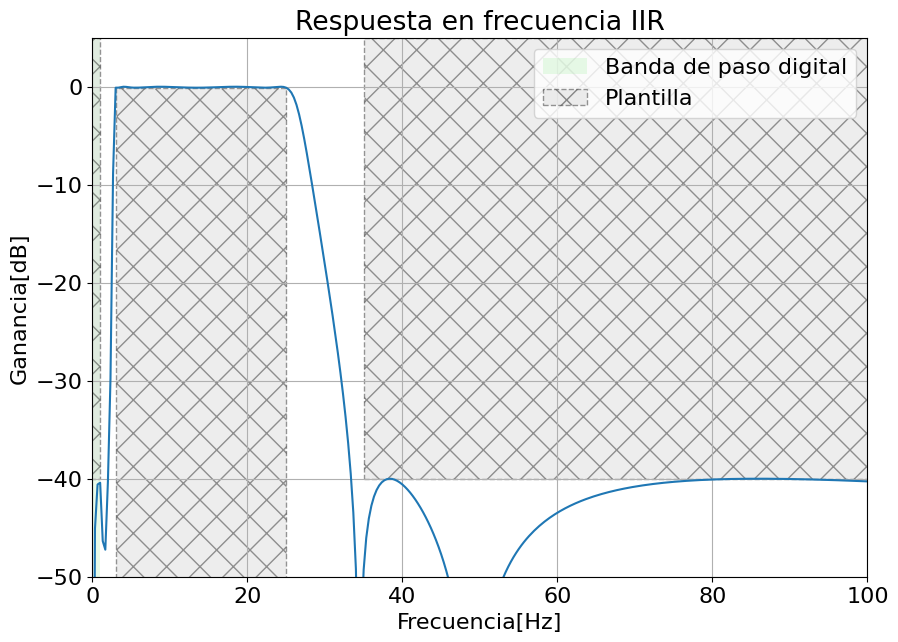

In [3]:
# Diseño de filtro IIR


bp_sos_butter=sig.iirdesign(wp=[wp1,wp2],ws=[ws1,ws2],gpass=ripple,gstop=atenuacion,analog=False,output='sos',fs=fs)
print(f"El filtro tiene {bp_sos_butter.shape[0]} SOS")

[w,Hz]=sig.sosfreqz(sos=bp_sos_butter,worN=1500,whole=False,fs=fs)

num_IIR, den_IIR = sig.sos2tf(bp_sos_butter)

# Delay de grupo 
delta_w=np.diff(w)
gd = -np.diff(np.unwrap(np.angle(Hz)))/delta_w
w_gd=w[:-1] 
# Plot de modulo y plantilla
plt.figure(1)
db=20*np.log10(np.maximum(np.abs(Hz),1e-5))
plt.plot(w,db)
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation = atenuacion)
plt.ylim(-50,5)
plt.xlim(0,100)
plt.grid(True)
#plt.yticks([0,-20,-40,-60])
plt.ylabel('Ganancia[dB]')
plt.xlabel('Frecuencia[Hz]')
plt.title('Respuesta en frecuencia IIR')

axes_hdl = plt.gca()
axes_hdl.legend()



<function matplotlib.pyplot.show(close=None, block=None)>

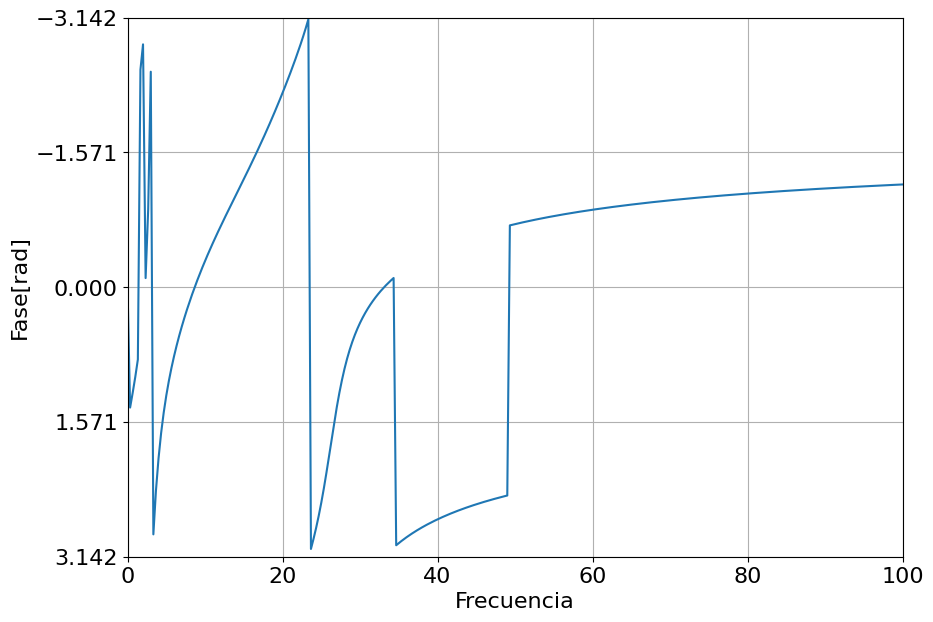

In [4]:

plt.figure(2)
plt.plot(w,np.angle(Hz))
plt.grid(True)
plt.yticks([np.pi,np.pi/2,0,-np.pi/2,-np.pi])
plt.ylim(np.pi,-np.pi)
plt.xlim(0,100)
plt.ylabel('Fase[rad]')
plt.xlabel('Frecuencia')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

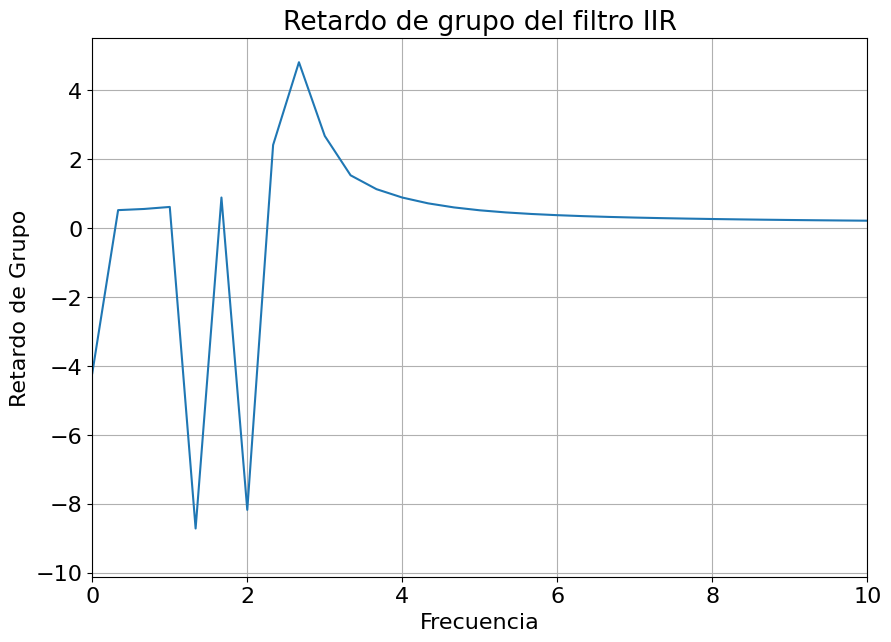

In [10]:

plt.figure(3)
plt.plot(w_gd,gd)
plt.grid(True)
plt.title('Retardo de grupo del filtro IIR')
plt.ylabel('Retardo de Grupo')
plt.xlim(0,10)
plt.xlabel('Frecuencia')
plt.show

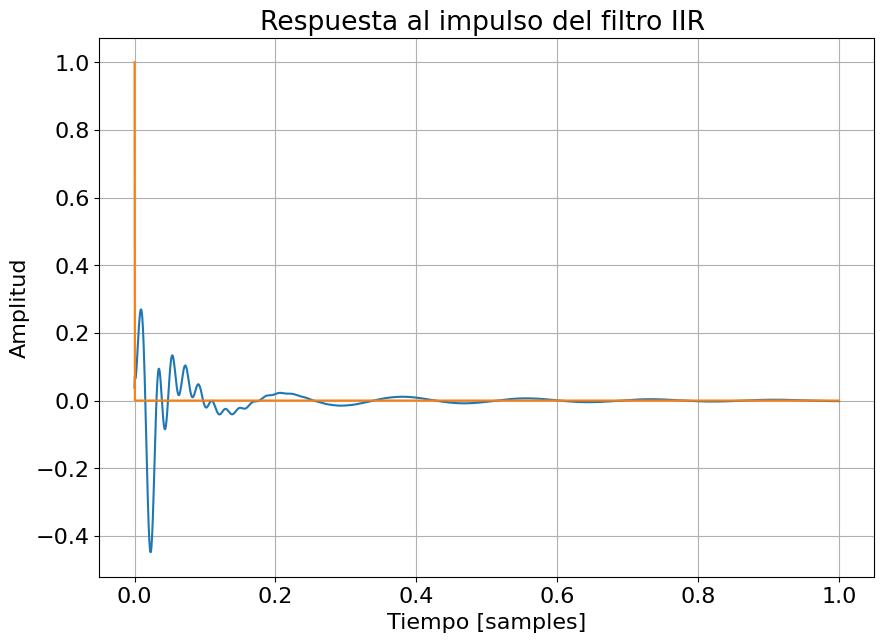

In [11]:

impulse = sig.unit_impulse(2000)
response = sig.sosfilt(bp_sos_butter, impulse)

plt.figure(4)
plt.plot(np.linspace(0,1, 2000), response * 10) # Para que se vea mas claro en el gráfico
plt.plot(np.linspace(0,1, 2000), impulse)
#plt.xlim([0,0.2])


plt.xlabel('Tiempo [samples]')
plt.ylabel('Amplitud')
plt.title('Respuesta al impulso del filtro IIR ')

plt.grid(True)
plt.show()

## Parte FIR

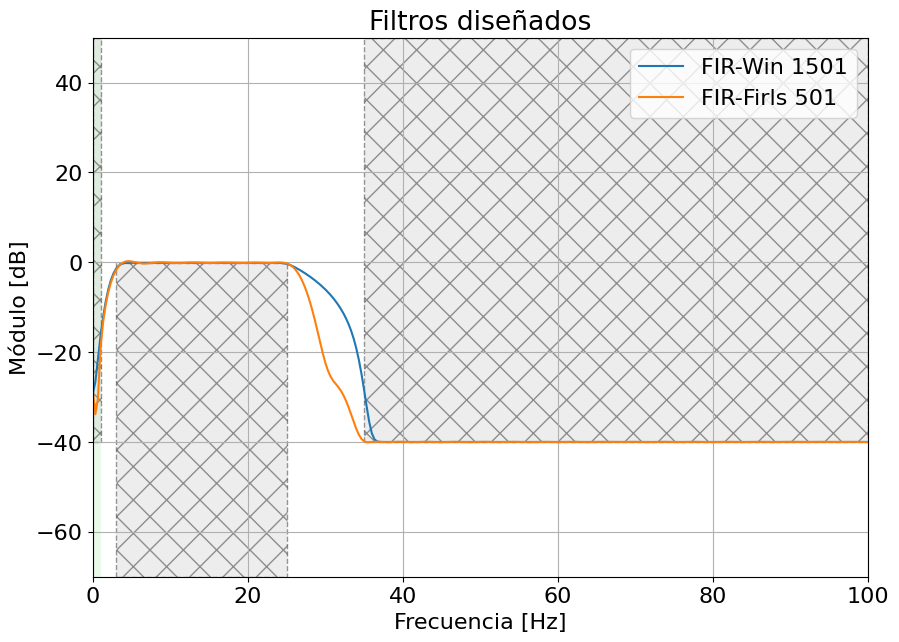

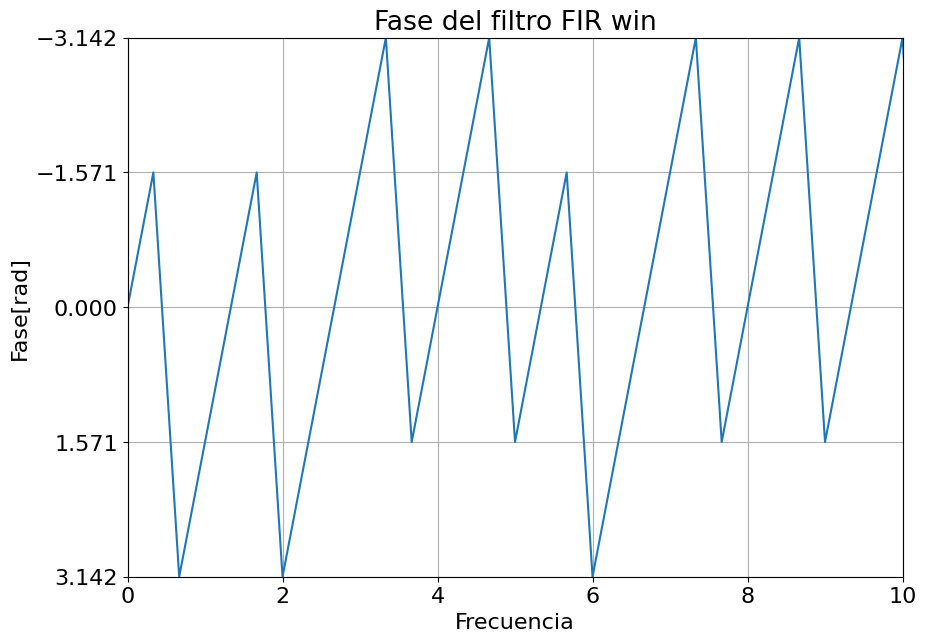

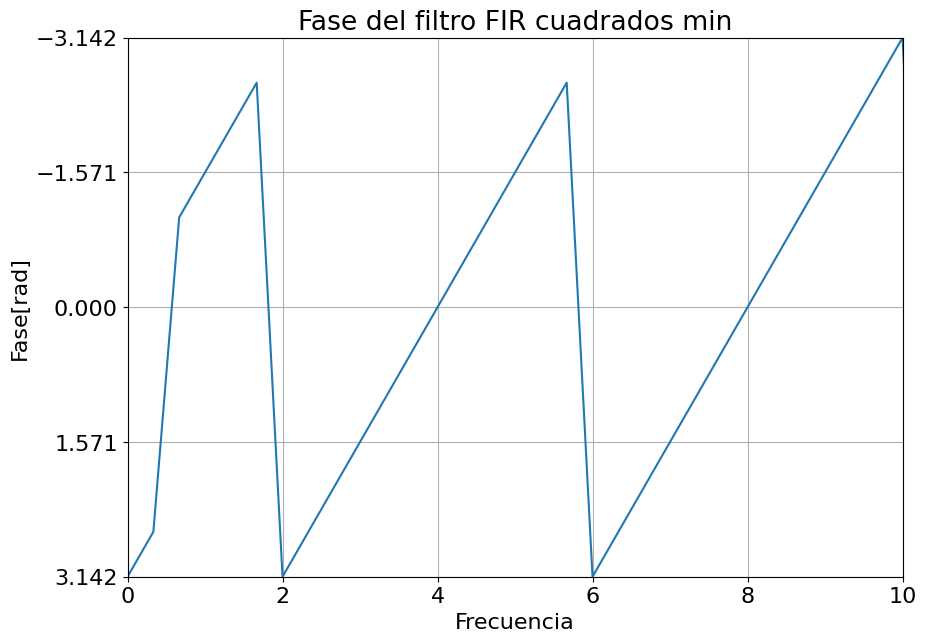

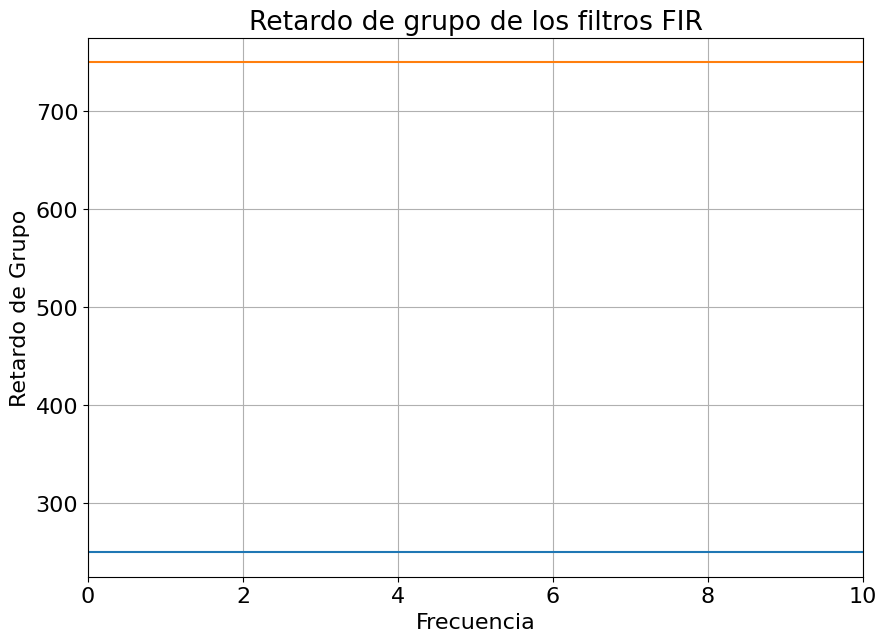

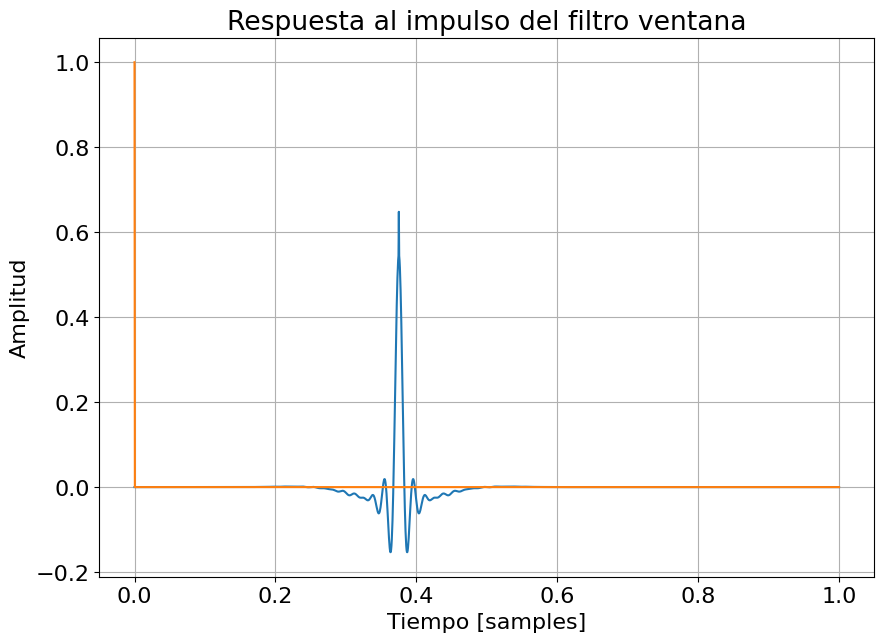

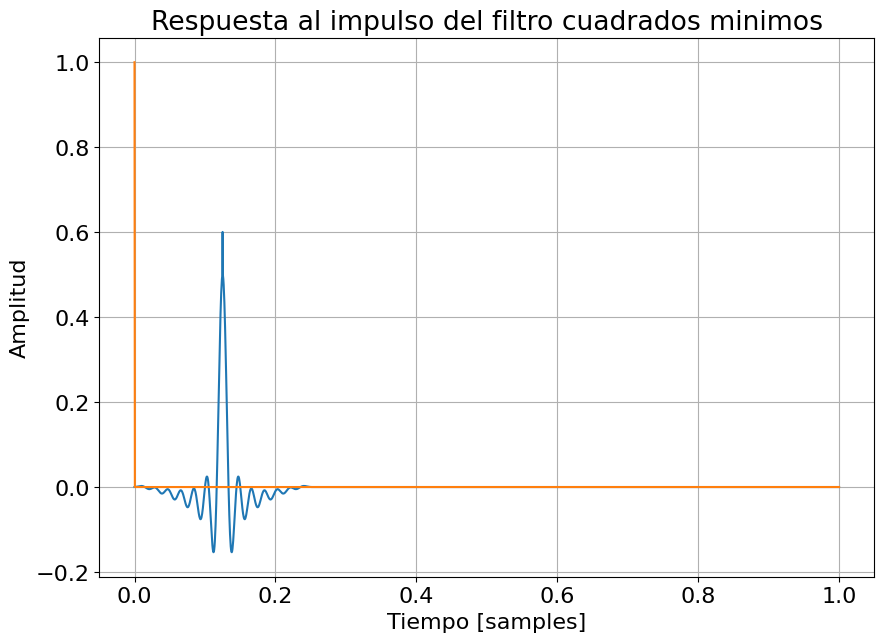

In [12]:

cant_coeficientes = 1501

# Filtro ventana 
num_win = sig.firwin2(cant_coeficientes, frecs, gains , window='blackmanharris' )

den = 1.0

# muestreo el filtro donde me interesa verlo según la plantilla.
w_1  = np.append(np.logspace(-1, 0.8, 250), np.logspace(0.9, 1.6, 250) )
w_1  = np.append(w, np.linspace(110, nyq_frec, 100, endpoint=True) ) / nyq_frec * np.pi

_, hh_win = sig.freqz(num_win, den, w_1)

# Filtro cuadrado minimos 
orden=501
pesos=[100,10,10000]
gains_1 = np.array([atenuacion, atenuacion, ripple, ripple, atenuacion, atenuacion])
n_firls=sig.firls(numtaps=orden,bands=frecs,desired=gains,weight=pesos)
_,H_firls=sig.freqz(n_firls,den,w_1)



# renormalizo el eje de frecuencia
w_1 = w_1 / np.pi * nyq_frec

# Graficos de modulos filtros FIR 
plt.figure(5)
plt.plot(w_1, 20 * np.log10(abs(hh_win)), label='FIR-Win {:d}'.format(num_win.shape[0]))
plt.plot(w_1, 20 * np.log10(abs(H_firls)), label='FIR-Firls {:d}'.format(n_firls.shape[0]))
plt.title('Filtros diseñados')
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Módulo [dB]')
plt.grid()
plt.axis([0, 100, -70, 50 ]);
axes_hdl = plt.gca()
axes_hdl.legend()
plot_plantilla(filter_type = 'bandpass', fpass = frecs[[2, 3]]* nyq_frec, ripple = ripple , fstop = frecs[ [1, 4] ]* nyq_frec, attenuation =atenuacion)

plt.figure(6)

plt.plot(w_1,np.angle(hh_win), label='FIR-Win {:d}'.format(num_win.shape[0]))
plt.grid(True)
plt.yticks([np.pi,np.pi/2,0,-np.pi/2,-np.pi])
plt.ylim(np.pi,-np.pi)
plt.xlim(0,10)
plt.title('Fase del filtro FIR win')
plt.ylabel('Fase[rad]')
plt.xlabel('Frecuencia')

plt.figure(7)
plt.plot(w_1,np.angle(H_firls), label='FIR-Win {:d}'.format(n_firls.shape[0]))
plt.grid(True)
plt.yticks([np.pi,np.pi/2,0,-np.pi/2,-np.pi])
plt.ylim(np.pi,-np.pi)
plt.xlim(0,10)
plt.title('Fase del filtro FIR cuadrados min')
plt.ylabel('Fase[rad]')
plt.xlabel('Frecuencia')


w_1, gd_firls = sig.group_delay((n_firls, den), w = 1500, whole = False, fs = fs)
w_1, gd_win = sig.group_delay((num_win, den), w = 1500, whole = False, fs = fs)

plt.figure(8)

plt.plot(w_1,gd_firls)
plt.plot(w_1,gd_win)
plt.xlim(0,10)
plt.grid(True)
plt.title('Retardo de grupo de los filtros FIR')
plt.ylabel('Retardo de Grupo')
plt.xlabel('Frecuencia')
plt.show




response_win=sig.lfilter(num_win,den,impulse)
# Filtro cuadrados minimos
response_ecg=sig.lfilter(n_firls,den,impulse)



plt.figure(9)
plt.plot(np.linspace(0,1, 2000), response_win * 10) # Para que se vea mas claro en el gráfico
plt.plot(np.linspace(0,1, 2000), impulse)
plt.xlabel('Tiempo [samples]')
plt.ylabel('Amplitud')
plt.title('Respuesta al impulso del filtro ventana')
plt.grid(True)
plt.show()

plt.figure(10)

plt.plot(np.linspace(0,1, 2000), response_ecg * 10) # Para que se vea mas claro en el gráfico
plt.plot(np.linspace(0,1, 2000), impulse)
plt.xlabel('Tiempo [samples]')
plt.ylabel('Amplitud')
plt.title('Respuesta al impulso del filtro cuadrados minimos')
plt.grid(True)
plt.show()




In [13]:
# Filtro IRR
ECG_f_butter=sig.sosfilt(bp_sos_butter,ecg_one_lead)
# Filtro ventana
ECG_f_win=sig.lfilter(num_win,den,ecg_one_lead)
# Filtro cuadrados minimos
ECG_f_filrs=sig.lfilter(n_firls,den,ecg_one_lead)

ECG_Filters=[ECG_f_butter,ECG_f_win,ECG_f_filrs]

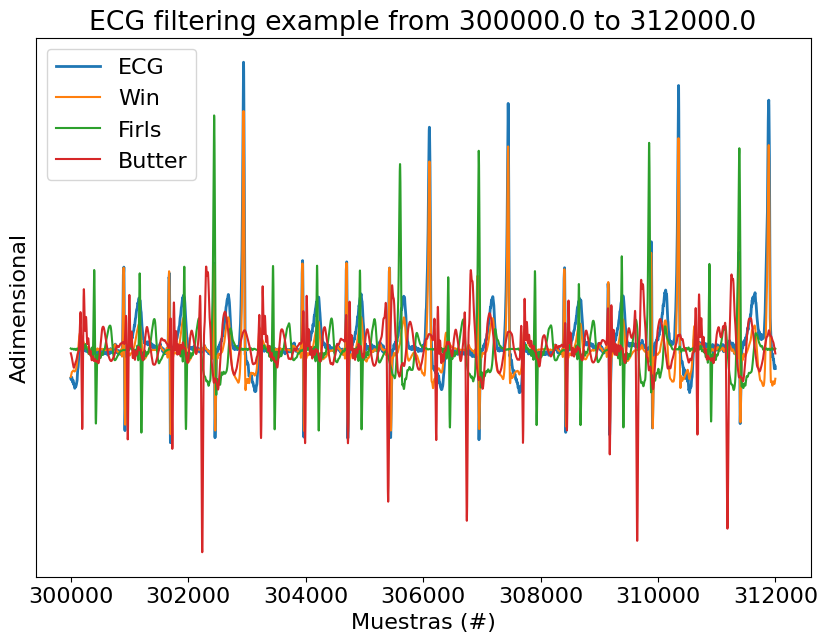

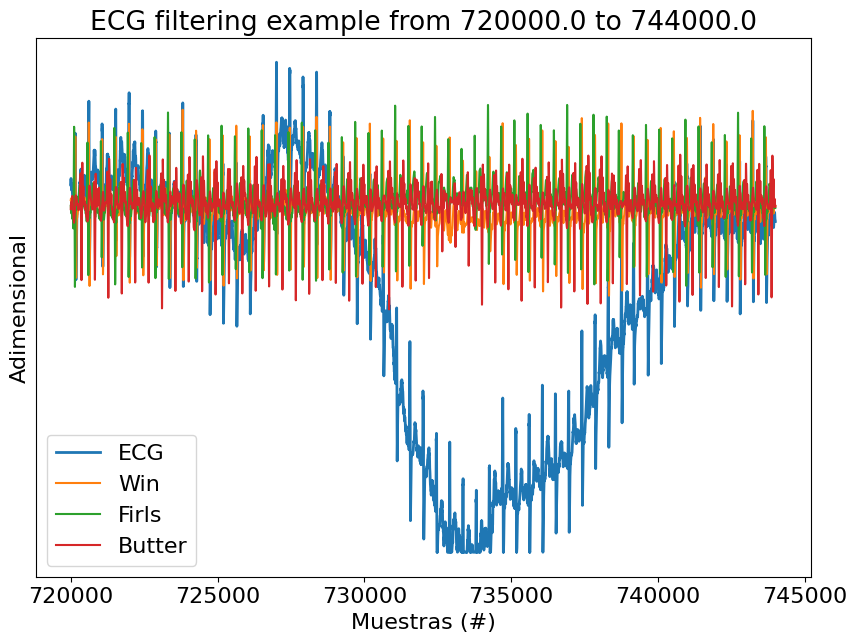

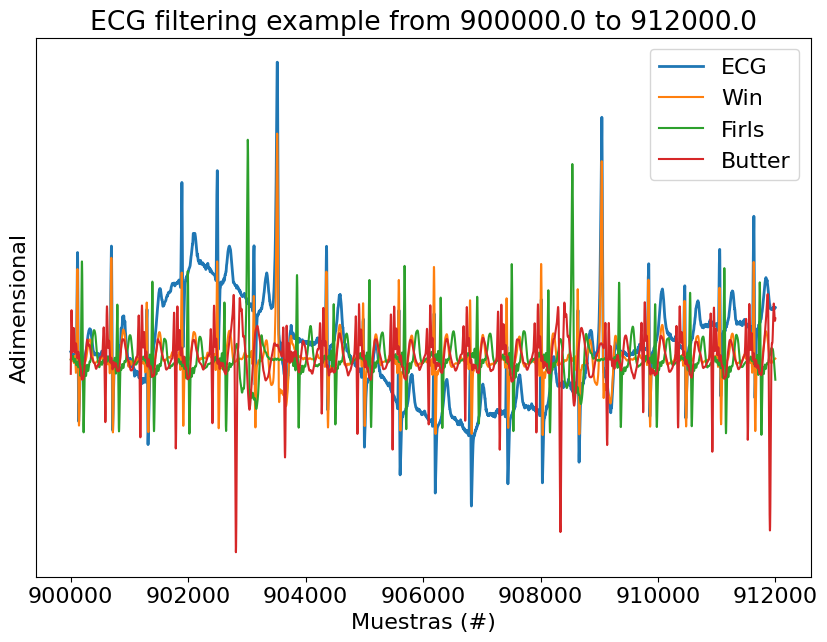

In [14]:

# demora = int(...)
# calcule la demora para cada caso, dicha demora adelantará la señal de salida, como puede ver más abajo.
demora = 750


# Segmentos de interés con ALTA contaminación

regs_interes = ( 
        np.array([5, 5.2]) *60*fs, # minutos a muestras
        np.array([12, 12.4]) *60*fs, # minutos a muestras
        np.array([15, 15.2]) *60*fs, # minutos a muestras
        )

for ii in regs_interes:
    
    # intervalo limitado de 0 a cant_muestras
    zoom_region = np.arange(np.max([0, ii[0]]), np.min([cant_muestras, ii[1]]), dtype='uint')
    
    plt.figure(figsize=(fig_sz_x, fig_sz_y), dpi= fig_dpi, facecolor='w', edgecolor='k')
    plt.plot(zoom_region, ecg_one_lead[zoom_region], label='ECG', linewidth=2)
    plt.plot(zoom_region, ECG_f_win[zoom_region + demora], label='Win')
    plt.plot(zoom_region, ECG_f_filrs[zoom_region + demora], label='Firls')
    plt.plot(zoom_region, ECG_f_butter[zoom_region + demora], label='Butter')
    
    plt.title('ECG filtering example from ' + str(ii[0]) + ' to ' + str(ii[1]) )
    plt.ylabel('Adimensional')
    plt.xlabel('Muestras (#)')
    
    axes_hdl = plt.gca()
    axes_hdl.legend()
    axes_hdl.set_yticks(())
            
    plt.show()

### Conclusiones: 

Preguntas: 

1)¿Qué pudo haber causado que los filtros no hayan sido eficientes para eliminar las interferencias?

Uno de los motivos por los cuales el filtrado puede no haber sido eficiente para eliminar las interferencias es por el nivel de ruido. Si la señal de entrada contiene un alto nivel de ruido, se dificulta eliminar las interferencias sin afectar negativamente a la señal original.

2)¿Qué pudo haber causado que los filtros no hayan sido inocuos respecto a las señales NO contaminadas?

Se le puede adjudicar este error al hecho de que en el diseño del filtro no se puede obtener un riple de exactamente 0dB, lo cual provoca una leve diferencia entre lo filtrado y la señal original. Ademas se observa que los picos del ECG son muy similares a un impulso, por lo cual, la respuesta al impulso tambien afecta al comportamiento del filtro.

Tambien hay que tener en cuenta para ambas respuestas la limitacion de resolución o precisión numérica, los filtros digitales pueden no ser capaces de eliminar eficazmente las interferencias más pequeñas o pueden introducir errores debido a la representación finita de los números en punto flotante.